In [1]:
import pandas as pd
import numpy as np
import pprint
import os
from datetime import datetime
import glob
import pandas as pd
import emgimporter

In [2]:
path=['emg_data','ipa_emg']
glob.glob(os.path.join(os.path.expanduser('~'),*path,'**'),recursive=True)
fList = [(os.path.basename(f.split('-',1)[0]), datetime.strptime(f.split('-',1)[1],"%Y%m%d-%H%M%S"), f)
          for f in glob.glob(os.path.join(os.path.expanduser('~'),*path,'**'),recursive=True)
          if not f.startswith('.') and not os.path.isdir(f)]
print(fList[2])

('data_4', datetime.datetime(2017, 5, 23, 12, 46, 47), '/home/myo/emg_data/ipa_emg/data_4-20170523-124647')


In [3]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.layouts import column, row
from bokeh.palettes import Spectral11, Category20, Set1
from bokeh.models import Range1d
output_notebook()

def plotdf(dfs, numlines=None,pltflag=None):
    # if just one pandas frame is given
    try:
        # get number of plottable columns if no exlicit numbers to plot are given
        if numlines == None:
            numlines = list(range(0,len(dfs.columns)))
        
        # create cut down color palette
        mypalette = [Set1[len(dfs.columns)][i] for i in numlines]
        
        # Only one plot
        if pltflag == None:
            p = figure()
            p.multi_line(xs = [dfs.index.values] *len(numlines),
                         ys = [dfs[n].values for n,i in enumerate(dfs) if i in numlines],
                         line_color = mypalette
                        )
            show(p)
            
        # Combined Plot
        elif pltflag == 'columns':
            pH = int(800/len(numlines))
            plist = [figure(plot_height=pH, y_range=Range1d(dfs.values.min(),dfs.values.max()), title=str(f)) for f in numlines]
            for i,p in enumerate(plist):
                p.line( x = dfs.index.values,
                        y = dfs[numlines[i]].values,
                        line_color = mypalette[i])
            show(column(*plist))
    
    # If list of emg data is given
    except:
        if numlines == None:
            numlines = list(range(0,len(dfs[0].columns)))
        
        # create cut down color palette
        mypalette = [Set1[len(dfs[0].columns)][i] for i in numlines]
        
        pH = int(800/len(numlines))
        yranges = Range1d(min([f.values.min() for f in dfs]),max([f.values.max() for f in dfs]))
        xranges = Range1d(min([f.index.values.min() for f in dfs]),max([f.index.values.max() for f in dfs]))
        plist = [figure(plot_height=pH, y_range=yranges, x_range=xranges, title=str(f)) for f in numlines]
        for i,p in enumerate(plist):
            p.multi_line( xs =[f.index.values for f in dfs],
                          ys = [f[numlines[i]].values for f in dfs],
                          line_color = mypalette[i])
        show(column(*plist))
            


Loading BokehJS ...

In [4]:
dic = { 1: 'Tasse aufnehmen', 
        2: 'Tasse halten',
        3: 'Tasse abstellen',
        4: 'Tasse hoch&runter',
        8: 'Ruhe (Supination)',
        9: 'Ruhe (Pronation)'
      }
its = ['cupv1','cupv2','kettlev1']

In [5]:
a = emgimporter.import_data(path=['emg_data','ipa_emg'])

In [6]:
feed_dic = emgimporter.import_folder(its,dic,path=['emg_data','ipa_emg'])

In [7]:
gesture = 1
db = 0
print('Database: ',its[db])
print('Gesture:  ',dic[feed_dic[its[db]][gesture-1][0]])
plotdf(feed_dic[its[db]][gesture-1][1])

Database:  cupv1
Gesture:   Tasse aufnehmen


/home/myo/anaconda3/envs/tensorflow/lib/python3.6/site-packages/bokeh/core/json_encoder.py:73: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  if pd and isinstance(obj, pd.tslib.Timestamp):


In [8]:
from keras.layers.convolutional import Conv1D
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LocallyConnected2D
from keras.layers import Conv2D, MaxPooling2D, LSTM
from keras.layers.normalization import BatchNormalization
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot



Using TensorFlow backend.


In [9]:
# Network architecture
neurons_per_layer = 16
hidden_layers     = 1
output_classes    = 2
activation        = 'relu'

# Traindata
data_arch = {   0: (7,8,9),
                1: (2,4),
             }


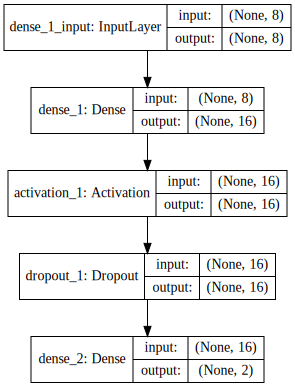

In [10]:
model = Sequential()
model.add(Dense(neurons_per_layer,input_shape=(8,)))
model.add(Activation(activation))
model.add(Dropout(0.2))

for i in range(1,hidden_layers):
    model.add(Dense(neurons_per_layer))
    model.add(Activation(activation))
    model.add(Dropout(0.2))



if len(data_arch) < 0:
    model.add(Dense(1,activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'], class_mode="binary" )
else:
    model.add(Dense(len(data_arch),activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'], class_mode="sparse" )

    
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))


In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                144       
_________________________________________________________________
activation_1 (Activation)    (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 34        
Total params: 178.0
Trainable params: 178.0
Non-trainable params: 0.0
_________________________________________________________________


In [12]:
x,y = emgimporter.prep_data(feed_dic,data_arch)

In [13]:
y_cut_train, y_cut_test, x_cut_train, x_cut_test = emgimporter.split_data(x,y,splitratio=0.05,shuffle=True)

In [14]:
print(x_cut_train.shape)
print(y_cut_train)

(11357, 8)
[[ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 ..., 
 [ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]]


In [15]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss',patience=10,min_delta=0.002)
model.fit(x_cut_train,y_cut_train,epochs = 1000, batch_size = 200, validation_split=0.1, shuffle=True, callbacks = [early_stopping])

/home/myo/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:2094: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


Train on 10221 samples, validate on 1136 samples
Epoch 1/1000
10221/10221 [==============================] - 1s - loss: 7.8300 - acc: 0.4378 - val_loss: 1.1845 - val_acc: 0.8116
Epoch 2/1000
10221/10221 [==============================] - 0s - loss: 4.7601 - acc: 0.6370 - val_loss: 0.5614 - val_acc: 0.8618
Epoch 3/1000
10221/10221 [==============================] - 0s - loss: 2.9072 - acc: 0.7656 - val_loss: 0.2547 - val_acc: 0.9771
Epoch 4/1000
10221/10221 [==============================] - 0s - loss: 1.6214 - acc: 0.8622 - val_loss: 0.2656 - val_acc: 0.9806
Epoch 5/1000
10221/10221 [==============================] - 0s - loss: 1.0865 - acc: 0.9058 - val_loss: 0.2530 - val_acc: 0.9815
Epoch 6/1000
10221/10221 [==============================] - 0s - loss: 0.7722 - acc: 0.9299 - val_loss: 0.2498 - val_acc: 0.9824
Epoch 7/1000
10221/10221 [==============================] - 0s - loss: 0.5493 - acc: 0.9492 - val_loss: 0.1756 - val_acc: 0.9868
Epoch 8/1000
10221/10221 [======================

10221/10221 [==============================] - 0s - loss: 0.0402 - acc: 0.9961 - val_loss: 0.0118 - val_acc: 0.9974
Epoch 64/1000
10221/10221 [==============================] - 0s - loss: 0.0408 - acc: 0.9964 - val_loss: 0.0101 - val_acc: 0.9974
Epoch 65/1000
10221/10221 [==============================] - 0s - loss: 0.0373 - acc: 0.9966 - val_loss: 0.0122 - val_acc: 0.9974
Epoch 66/1000
10221/10221 [==============================] - 0s - loss: 0.0377 - acc: 0.9970 - val_loss: 0.0100 - val_acc: 0.9974


In [16]:
scores = model.evaluate(x_cut_test, y_cut_test, batch_size=1)

581/597 [============================>.] - ETA: 0s

In [17]:
print(model.metrics_names)
print(scores)

['loss', 'acc']
[0.033542823216363343, 0.99664991624790622]


In [18]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                144       
_________________________________________________________________
activation_1 (Activation)    (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 34        
Total params: 178.0
Trainable params: 178.0
Non-trainable params: 0.0
_________________________________________________________________


In [19]:
model.save("/home/myo/models/v1_dense.h5")